<a href="https://colab.research.google.com/github/dineshssdn-867/CSE541_Computer_Vision_2022_5/blob/master/code/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and config files

In [1]:
# !pip install scipy==1.1.0

In [2]:
import platform
platform.python_version()

'3.6.10'

In [3]:
# !pip install tensorflow==2.1
# !pip install keras==2.3.1

In [4]:
import cv2
import scipy.io
import os
import gc
import sklearn.preprocessing
import matplotlib
import tensorflow
import keras.optimizers
import warnings
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter 
from keras import backend as K
from keras.models import Sequential
from keras.regularizers import l2
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D, AveragePooling3D 
from tensorflow.keras.layers import BatchNormalization, Activation, Input
from tensorflow.keras import layers
from PIL import Image
# from scipy.misc import imresize
from keras.models import model_from_json
from datetime import datetime
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

In [5]:
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D

In [6]:
C3D_MEAN_PATH = 'https://github.com/adamcasson/c3d/releases/download/v0.1/c3d_mean.npy'

## Parameters

In [9]:
c3d_model_weights = 'E:/LY Project/C3D_Sport1M_weights_keras_2.2.4.h5'
abnormal_videos_path="E:/LY Project/Anomaly Videos"
normal_videos_path="E:/LY Project/Training-Normal-Videos-Part-2"
raw_normal_train_features_c3d="E:/LY Project/Raw Normal videos features C3d"
raw_abnormal_train_features_c3d="E:/LY Project/Raw Anomaly videos features C3d"
processed_normal_train_features_c3d="E:/LY Project/Pre-processed Normal Video features C3d"
processed_abnormal_train_features_c3d="E:/LY Project/Pre-processed Anomaly video features C3d"

output_dir = "E:/LY Project/Trained_models/"
output_folder_c3d = 'E:/LY Project/output_videos'


In [11]:
frame_height = 240
frame_width = 320
channels = 3

c3d_frame_count = 16

In [12]:
features_per_bag = 32

## Chunks work

In [13]:
def divide_chunks(l, n):
    """Apply divide_chunks to an array, getting chunks of
    of specified size
    """
    for i in range(0, len(l), n): 
        yield l[i:i + n]

## Array Util

In [14]:
def sliding_window(arr, size, stride):
    """Apply sliding window to an array, getting chunks of
    of specified size using the specified stride
    :param arr: Array to be divided
    :param size: Size of the chunks
    :param stride: Number of frames to skip for the next chunk
    :returns: Tensor with the resulting chunks
    :rtype: np.ndarray
    """
    num_chunks = int((len(arr) - size) / stride) + 2
    result = []
    for i in range(0,  num_chunks * stride, stride):
        if len(arr[i:i + size]) > 0:
            result.append(arr[i:i + size])
    return np.array(result)


def interpolate(features, features_per_bag):
    """Transform a bag with an arbitrary number of features into a bag
    with a fixed amount, using interpolation of consecutive features
    :param features: Bag of features to pad
    :param features_per_bag: Number of features to obtain
    :returns: Interpolated features
    :rtype: np.ndarray
    """
#     feature_size = np.array(features).shape[0]
    feature_size = np.array(features).shape[1]
    interpolated_features = np.zeros((features_per_bag, feature_size))
    interpolation_indices = np.round(np.linspace(0, len(features) - 1, num=features_per_bag + 1))
    count = 0
    for index in range(0, len(interpolation_indices)-1):
        start = int(interpolation_indices[index])
        end = int(interpolation_indices[index + 1])

        assert end >= start

        if start == end:
            temp_vect = features[start, :]
        else:
            temp_vect = np.mean(features[start:end+1, :], axis=0)

        temp_vect = temp_vect / np.linalg.norm(temp_vect)

        if np.linalg.norm(temp_vect) == 0:
            print("Error")

        interpolated_features[count,:]=temp_vect
        count = count + 1
    del interpolation_indices
    gc.collect(generation=2)
    return np.array(interpolated_features)


def extrapolate(outputs, num_frames):
    """Expand output to match the video length
    :param outputs: Array of predicted outputs
    :param num_frames: Expected size of the output array
    :returns: Array of output size
    :rtype: np.ndarray
    """

    extrapolated_outputs = []
    extrapolation_indices = np.round(np.linspace(0, len(outputs) - 1, num=num_frames))
    for index in extrapolation_indices:
        extrapolated_outputs.append(outputs[int(index)])
    del extrapolation_indices
    gc.collect(generation=2)
    return np.array(extrapolated_outputs)

# Video Util

In [15]:
def get_video_clips(video_path, frame_count):
    """Divides the input video into non-overlapping clips
    :param video_path: Path to the video
    :returns: Array with the fragments of video
    :rtype: np.ndarray
    """
    frames = get_video_frames(video_path)
    clips = sliding_window(frames, frame_count, frame_count)
    return clips, len(frames)

In [16]:
def get_video_frames(video_path):
    """Reads the video given a file path
    :param video_path: Path to the video
    :returns: Video as an array of frames
    :rtype: np.ndarray
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            del frame
        else:
            break
    cap.release()
    del cap
    gc.collect(generation=2)
    return frames

# Video pre-processing C3d

---



In [17]:
def preprocess_input_c3d(video):
    """Preprocess video input to make it suitable for feature extraction.
    The video is resized, cropped, resampled and training mean is substracted
    to make it suitable for the network
    :param video: Video to be processed
    :returns: Preprocessed video
    :rtype: np.ndarray
    """

    intervals = np.ceil(np.linspace(0, video.shape[0] - 1, 16)).astype(int)
    frames = video[intervals]

    # Reshape to 128x171
    reshape_frames = np.zeros((frames.shape[0], 128, 171, frames.shape[3]))
    for i, img in enumerate(frames):
#         heatmap = imresize(heatmap, input_dims, interp='bicubic', mode='F')
# heatmap = np.array(Image.fromarray(obj=heatmap, mode='F').resize(size=input_dims, resample=Image.BICUBIC))
# img = np.array(Image.fromarray(obj=img).resize(size=(128, 171), resample =Image.BICUBIC))
#         img = imresize(img, (128, 171), 'bicubic')
        img = np.array(Image.fromarray(obj=img).resize(size=(171, 128), resample =Image.BICUBIC))
        reshape_frames[i, :, :, :] = img
        del img

    mean_path = get_file('c3d_mean.npy',
                         C3D_MEAN_PATH,
                         cache_subdir='models',
                         md5_hash='08a07d9761e76097985124d9e8b2fe34')

    mean = np.load(mean_path)
    reshape_frames -= mean
    # Crop to 112x112
    reshape_frames = reshape_frames[:, 8:120, 30:142, :]
    # Add extra dimension for samples
    reshape_frames = np.expand_dims(reshape_frames, axis=0)
    del intervals
    del frames
    gc.collect(generation=2)
    return reshape_frames

# Segment Utils

In [19]:
def transform_into_segments(features, n_segments=32):
    """This will convert the vector 
    into 32 segments of feature vectors"""
    if features.shape[0] < n_segments:
        raise RuntimeError(
            "Number of prev segments lesser than expected output size"
        )

    cuts = np.linspace(0, features.shape[0], n_segments,
                       dtype=int, endpoint=False)

    new_feats = []
    for i, j in zip(cuts[:-1], cuts[1:]):
        new_feats.append(np.mean(features[i:j,:], axis=0))

    new_feats.append(np.mean(features[cuts[-1]:,:], axis=0))

    new_feats = np.array(new_feats)
    new_feats = sklearn.preprocessing.normalize(new_feats, axis=1)
    del cuts
    gc.collect(generation=2)
    return new_feats

# C3d

In [20]:
def C3D(weights='sports1M'):
    """Creation of the full C3D architecture
    :param weights: Weights to be loaded into the network. If None,
    the network is randomly initialized.
    :returns: Network model
    :rtype: keras.model
    """

    if weights not in {'sports1M', None}:
        raise ValueError('weights should be either be sports1M or None')

    if K.image_data_format() == 'channels_last':
        shape = (16, 112, 112, 3)
    else:
        shape = (3, 16, 112, 112)

    model = Sequential()
    model.add(
        Conv3D(64,
               3,
               activation='relu',
               padding='same',
               name='conv1',
               input_shape=shape))
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2),
                     strides=(1, 2, 2),
                     padding='same',
                     name='pool1'))

    model.add(Conv3D(128, 3, activation='relu', padding='same', name='conv2'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool2'))

    model.add(Conv3D(256, 3, activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(256, 3, activation='relu', padding='same', name='conv3b'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool3'))

    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv4b'))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool4'))

    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv5a'))
    model.add(Conv3D(512, 3, activation='relu', padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))
    model.add(
        MaxPooling3D(pool_size=(2, 2, 2),
                     strides=(2, 2, 2),
                     padding='valid',
                     name='pool5'))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    if weights == 'sports1M':
        model.load_weights(c3d_model_weights)

    return model

In [21]:
def c3d_feature_extractor():
    """Creation of the feature extraction architecture. This network is
    formed by a subset of the original C3D architecture (from the
    beginning to fc6 layer)
    :returns: Feature extraction model
    :rtype: keras.model
    """
    model = C3D()
    layer_name = 'fc6'
    feature_extractor_model = Model(inputs=model.input,
                                    outputs=model.get_layer(layer_name).output)
    return feature_extractor_model

In [22]:
feature_extractor = c3d_feature_extractor()

# Extract Features

## Normal Videos

In [28]:
normal_videos = os.listdir(normal_videos_path)
normal_videos.sort()
chunk = list(divide_chunks(normal_videos, 5))

### C3d

In [29]:
print("Processing normal videos in chunks...")
for vid_name1 in chunk:
    for vid_name in vid_name1:
        print("Processing {}".format(vid_name))
        vid_path = os.path.join(normal_videos_path, vid_name)
        feats_path = os.path.join(
            raw_normal_train_features_c3d, vid_name[:-9] + ".npy")

        clips, frames = get_video_clips(vid_path, c3d_frame_count)
        print(frames)
        if frames > 8000:
            continue
        # Remove last clip if number of frames is not equal to 16
        if frames % 16 != 0:
            clips = clips[:-1]

        prep_clips = [preprocess_input_c3d(np.array(clip)) for clip in clips]
        prep_clips = np.vstack(prep_clips)

        features = feature_extractor.predict(prep_clips)
        del prep_clips
        features = sklearn.preprocessing.normalize(features, axis=1)   
        with open(feats_path, "wb") as f:
            np.save(f, features)
        del features
        gc.collect(generation=2)

Processing normal videos in chunks...
Processing Normal_Videos948_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3595
Processing Normal_Videos949_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1111
Processing Normal_Videos950_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2412


In [30]:
raw_normal_train_features_c3d_list=os.listdir(raw_normal_train_features_c3d)
for filename in os.listdir(raw_normal_train_features_c3d):
    print("Processing {}".format(filename))
    raw_file_path = os.path.join(
        raw_normal_train_features_c3d, filename
    )
    processed_file_path = os.path.join(
        processed_normal_train_features_c3d, filename
    )
    with open(raw_file_path, "rb") as f:
        feats = np.load(f, allow_pickle=True)

    try:
        new_feats = transform_into_segments(feats)
        with open(processed_file_path, "wb") as f:
            np.save(f, new_feats, allow_pickle=True)
    except RuntimeError:
        print("Video {} too short".format(filename))

Processing Normal_Videos004.npy
Processing Normal_Videos007.npy
Processing Normal_Videos009.npy
Processing Normal_Videos011.npy
Processing Normal_Videos012.npy
Processing Normal_Videos013.npy
Processing Normal_Videos016.npy
Processing Normal_Videos020.npy
Video Normal_Videos020.npy too short
Processing Normal_Videos029.npy
Processing Normal_Videos038.npy
Processing Normal_Videos039.npy
Processing Normal_Videos040.npy
Processing Normal_Videos049.npy
Processing Normal_Videos053.npy
Video Normal_Videos053.npy too short
Processing Normal_Videos054.npy
Processing Normal_Videos055.npy
Video Normal_Videos055.npy too short
Processing Normal_Videos060.npy
Processing Normal_Videos062.npy
Processing Normal_Videos068.npy
Processing Normal_Videos071.npy
Processing Normal_Videos072.npy
Processing Normal_Videos074.npy
Processing Normal_Videos075.npy
Processing Normal_Videos078.npy
Processing Normal_Videos080.npy
Processing Normal_Videos088.npy
Processing Normal_Videos093.npy
Processing Normal_Videos0

## Anomaly Videos

In [43]:
abnormal_videos = os.listdir(abnormal_videos_path)
abnormal_videos.sort()
chunk = list(divide_chunks(abnormal_videos, 5))

### C3d

In [44]:
print("Processing abnormal videos in chunks...")
for vid_name1 in chunk:
    for vid_name in vid_name1:
        print("Processing {}".format(vid_name))
        vid_path = os.path.join(abnormal_videos_path, vid_name)
        feats_path = os.path.join(
            raw_abnormal_train_features_c3d, vid_name[:-9] + ".npy")

        clips, frames = get_video_clips(vid_path, c3d_frame_count)
        print(frames)
        if frames > 8000:
            continue
        # Remove last clip if number of frames is not equal to 16
        if frames % 16 != 0:
            clips = clips[:-1]

        prep_clips = [preprocess_input_c3d(np.array(clip)) for clip in clips]
        prep_clips = np.vstack(prep_clips)

        features = feature_extractor.predict(prep_clips)
        del prep_clips
        features = sklearn.preprocessing.normalize(features, axis=1)   
        with open(feats_path, "wb") as f:
            np.save(f, features)
        del features
        gc.collect(generation=2)

Processing abnormal videos in chunks...
Processing Vandalism001_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1434
Processing Vandalism002_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1841
Processing Vandalism003_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1469
Processing Vandalism004_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2820
Processing Vandalism005_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1624
Processing Vandalism006_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


811
Processing Vandalism007_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1146
Processing Vandalism008_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


12589
Processing Vandalism009_x264.mp4
1328
Processing Vandalism010_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3945
Processing Vandalism011_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


12449
Processing Vandalism012_x264.mp4
845
Processing Vandalism013_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2379
Processing Vandalism014_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


429
Processing Vandalism015_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2982
Processing Vandalism016_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


5810
Processing Vandalism017_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1011
Processing Vandalism018_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


5557
Processing Vandalism019_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2047
Processing Vandalism020_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1447
Processing Vandalism021_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1362
Processing Vandalism022_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3932
Processing Vandalism023_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


6301
Processing Vandalism024_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1004
Processing Vandalism025_x264.mp4
4304
Processing Vandalism026_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


969
Processing Vandalism027_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


701
Processing Vandalism028_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


4495
Processing Vandalism029_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


456
Processing Vandalism030_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1437
Processing Vandalism031_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1799
Processing Vandalism032_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


674
Processing Vandalism033_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2265
Processing Vandalism034_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1756
Processing Vandalism035_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1188
Processing Vandalism036_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1443
Processing Vandalism037_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3019
Processing Vandalism038_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2825
Processing Vandalism039_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


899
Processing Vandalism040_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


1037
Processing Vandalism041_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


4868
Processing Vandalism042_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3596
Processing Vandalism043_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


3243
Processing Vandalism044_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


4605
Processing Vandalism045_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


4358
Processing Vandalism046_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2099
Processing Vandalism047_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


2483
Processing Vandalism048_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


7183
Processing Vandalism049_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


7999
Processing Vandalism050_x264.mp4


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


899


In [31]:
raw_abnormal_train_features_c3d_list=os.listdir(raw_abnormal_train_features_c3d)
for filename in os.listdir(raw_abnormal_train_features_c3d):
    print("Processing {}".format(filename))
    raw_file_path = os.path.join(
        raw_abnormal_train_features_c3d, filename
    )
    processed_file_path = os.path.join(
        processed_abnormal_train_features_c3d, filename
    )
    with open(raw_file_path, "rb") as f:
        feats = np.load(f, allow_pickle=True)

    try:
        new_feats = transform_into_segments(feats)
        with open(processed_file_path, "wb") as f:
            np.save(f, new_feats, allow_pickle=True)
    except RuntimeError:
        print("Video {} too short".format(filename))

Processing Abuse001.npy
Processing Abuse002.npy
Processing Abuse003.npy
Processing Abuse005.npy
Processing Abuse006.npy
Processing Abuse007.npy
Processing Abuse009.npy
Processing Abuse010.npy
Processing Abuse011.npy
Processing Abuse012.npy
Processing Abuse013.npy
Processing Abuse014.npy
Processing Abuse015.npy
Processing Abuse016.npy
Processing Abuse017.npy
Processing Abuse018.npy
Processing Abuse019.npy
Processing Abuse020.npy
Processing Abuse021.npy
Processing Abuse022.npy
Processing Abuse023.npy
Processing Abuse024.npy
Processing Abuse025.npy
Processing Abuse026.npy
Processing Abuse027.npy
Processing Abuse028.npy
Processing Abuse029.npy
Video Abuse029.npy too short
Processing Abuse030.npy
Processing Abuse031.npy
Processing Abuse032.npy
Processing Abuse033.npy
Processing Abuse034.npy
Processing Abuse035.npy
Processing Abuse036.npy
Processing Abuse037.npy
Processing Abuse038.npy
Processing Abuse040.npy
Processing Abuse041.npy
Processing Abuse043.npy
Processing Abuse044.npy
Processing 

# AI Train

## Parameters for traning model

In [32]:
normal_list_c3d = os.listdir(processed_normal_train_features_c3d)
normal_list_c3d.sort()
abnormal_list_c3d = os.listdir(processed_abnormal_train_features_c3d)
abnormal_list_c3d.sort()

weights_path_c3d = output_dir + 'weights_c3d.mat'
model_path_c3d = output_dir + 'model_c3d.json'

## DNN Model C3d

In [33]:
def classifier_c3d_model():
    """Build the classifier
    :returns: Classifier model
    :rtype: keras.Model
    """
    model = Sequential()
    model.add(Dense(512, input_dim=4096, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(32, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(1, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='sigmoid'))
    return model

## Data loading

In [35]:
def load_batch_train(normal_path, normal_list, abnormal_path, abnormal_list):

    batchsize=60
    n_exp = int(batchsize/2)

    num_normal = len(normal_list)
    num_abnormal = len(abnormal_list)

    abnor_list_idx = np.random.permutation(num_abnormal)
    abnor_list = abnor_list_idx[:n_exp]
    norm_list_idx = np.random.permutation(num_normal)
    norm_list = norm_list_idx[:n_exp]

    abnormal_feats = []
    for video_idx in abnor_list:
        video_path = os.path.join(abnormal_path, abnormal_list[video_idx])
        with open(video_path, "rb") as f:
            feats = np.load(f)
        abnormal_feats.append(feats)

    normal_feats = []
    for video_idx in norm_list:
        video_path = os.path.join(normal_path, normal_list[video_idx])
        with open(video_path, "rb") as f:
            feats = np.load(f)
        normal_feats.append(feats)


    all_feats = np.vstack((*abnormal_feats, *normal_feats))
    all_labels = np.zeros(32*batchsize, dtype='uint8')

    all_labels[:32*n_exp] = 1

    return  all_feats, all_labels

## Loss function

In [36]:
def custom_objective(y_true, y_pred):

    y_true = K.reshape(y_true, [-1])
    y_pred = K.reshape(y_pred, [-1])
    n_seg = 32
    nvid = 60
    n_exp = int(nvid / 2)

    max_scores_list = []
    z_scores_list = []
    temporal_constrains_list = []
    sparsity_constrains_list = []

    for i in range(0, n_exp, 1):

        video_predictions = y_pred[i*n_seg:(i+1)*n_seg]

        max_scores_list.append(K.max(video_predictions))
        temporal_constrains_list.append(
            K.sum(K.pow(video_predictions[1:] - video_predictions[:-1], 2))
        )
        sparsity_constrains_list.append(K.sum(video_predictions))

    for j in range(n_exp, 2*n_exp, 1):

        video_predictions = y_pred[j*n_seg:(j+1)*n_seg]
        max_scores_list.append(K.max(video_predictions))

    max_scores = K.stack(max_scores_list)
    temporal_constrains = K.stack(temporal_constrains_list)
    sparsity_constrains = K.stack(sparsity_constrains_list)

    for ii in range(0, n_exp, 1):
        max_z = K.maximum(1 - max_scores[:n_exp] + max_scores[n_exp+ii], 0)
        z_scores_list.append(K.sum(max_z))

    z_scores = K.stack(z_scores_list)
    z = K.mean(z_scores)

    return z + \
        0.00008*K.sum(temporal_constrains) + \
        0.00008*K.sum(sparsity_constrains)

## Model Initialization 

In [37]:
#Create Full connected Model
model_c3d = classifier_c3d_model()

## Compile model and define some parameters

In [38]:
adagrad = tf.keras.optimizers.Adagrad(lr=0.001, epsilon=1e-08)
model_c3d.compile(loss=custom_objective, optimizer=adagrad)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
if not os.path.exists(output_dir):
       os.makedirs(output_dir)

loss_graph =[]
num_iters = 4000
total_iterations = 0
batchsize=32
time_before = datetime.now()

## Train Model C3d

In [40]:
Loss, epochs = [], []

In [41]:
for it_num in range(num_iters):
    inputs, targets = load_batch_train(
        processed_normal_train_features_c3d, normal_list_c3d, processed_abnormal_train_features_c3d, abnormal_list_c3d
    )
    batch_loss = model_c3d.train_on_batch(inputs, targets)
    loss_graph = np.hstack((loss_graph, batch_loss))
    total_iterations += 1
    if total_iterations % 20 == 0:
        epochs.append(total_iterations)
        Loss.append(batch_loss)
        print ("Iteration={} took: {}, loss: {}".format(
            total_iterations, datetime.now() - time_before, batch_loss)
              )

Iteration=20 took: 0:00:14.044898, loss: 30.653682708740234
Iteration=40 took: 0:00:16.737240, loss: 30.339954376220703
Iteration=60 took: 0:00:19.463562, loss: 30.01643180847168
Iteration=80 took: 0:00:22.140175, loss: 29.90500831604004
Iteration=100 took: 0:00:24.806435, loss: 29.288759231567383
Iteration=120 took: 0:00:27.508313, loss: 28.691282272338867
Iteration=140 took: 0:00:30.447128, loss: 27.260866165161133
Iteration=160 took: 0:00:33.291435, loss: 26.786945343017578
Iteration=180 took: 0:00:36.159952, loss: 27.159963607788086
Iteration=200 took: 0:00:38.993993, loss: 25.81065559387207
Iteration=220 took: 0:00:41.834565, loss: 25.65152359008789
Iteration=240 took: 0:00:44.750988, loss: 26.693876266479492
Iteration=260 took: 0:00:47.582525, loss: 25.644672393798828
Iteration=280 took: 0:00:50.409309, loss: 24.931909561157227
Iteration=300 took: 0:00:53.240109, loss: 23.086692810058594
Iteration=320 took: 0:00:56.068874, loss: 23.799442291259766
Iteration=340 took: 0:00:58.9054

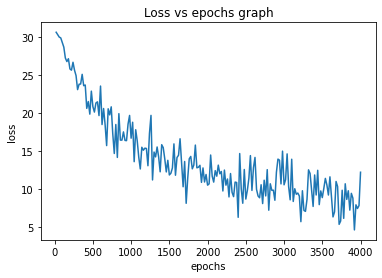

In [42]:
plt.plot(epochs, Loss)
plt.xlabel('epochs') 
plt.ylabel('loss') 
  
# displaying the title
plt.title("Loss vs epochs graph")
plt.show()

## Saving model

In [46]:
def load_model(json_path):
    model = model_from_json(open(json_path).read())
    return model

In [47]:
def save_model(model, json_path, weight_path):
    json_string = model.to_json()
    open(json_path, 'w').write(json_string)
    dict = {}
    i = 0
    for layer in model.layers:
        weights = layer.get_weights()
        my_list = np.zeros(len(weights), dtype=np.object)
        my_list[:] = weights
        dict[str(i)] = my_list
        i += 1
    scipy.io.savemat(weight_path, dict)

### C3d

In [49]:
print("Train Successful - Model saved")
save_model(model_c3d, model_path_c3d, weights_path_c3d)

Train Successful - Model saved


## Load Model

In [50]:
def conv_dict(dict2):
    """Prepare the dictionary of weights to be loaded by the network
    :param dict2: Dictionary to format
    :returns: The dictionary properly formatted
    :rtype: dict
    """
    dict = {}
    for i in range(len(dict2)):
        if str(i) in dict2:
            if dict2[str(i)].shape == (0, 0):
                dict[str(i)] = dict2[str(i)]
            else:
                weights = dict2[str(i)][0]
                weights2 = []
                for weight in weights:
                    if weight.shape in [(1, x) for x in range(0, 5000)]:
                        weights2.append(weight[0])
                    else:
                        weights2.append(weight)
                dict[str(i)] = weights2
    return dict

In [51]:
def load_weights(model, weights_file):
    """Loads the pretrained weights into the network architecture
    :param model: keras model of the network
    :param weights_file: Path to the weights file
    :returns: The input model with the weights properly loaded
    :rtype: keras.model
    """
    dict2 = sio.loadmat(weights_file)
    dict = conv_dict(dict2)
    i = 0
    for layer in model.layers:
        weights = dict[str(i)]
        layer.set_weights(weights)
        i += 1
    return model

In [52]:
def build_classifier_model(model, weights_path):
    """Build the classifier and load the pretrained weights
    :returns:
    :rtype:
    """
    model = load_weights(model, weights_path)
    return model

In [53]:
model_c3d = build_classifier_model(model_c3d, weights_path_c3d)

# Visualize

In [54]:
def visualize_clip(clip, convert_bgr=False, save_gif=False, file_path=None):
    num_frames = len(clip)
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)

    def update(i):
        if convert_bgr:
            frame = cv2.cvtColor(clip[i], cv2.COLOR_BGR2RGB)
        else:
            frame = clip[i]
        plt.imshow(frame)
        return plt

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 20ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, num_frames), interval=1)
    if save_gif:
        anim.save(file_path, dpi=80, writer='pillow')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()

In [55]:
def visualize_predictions(video_path, predictions, save_path):
    frames = get_video_frames(video_path)
    assert len(frames) == len(predictions)

    fig, ax = plt.subplots(figsize=(5, 5))
    fig.set_tight_layout(True)

    line = matplotlib.lines.Line2D([], [])

    fig_frame = plt.subplot(2, 1, 1)
    img = fig_frame.imshow(frames[0])
    fig_prediction = plt.subplot(2, 1, 2)
    fig_prediction.set_xlim(0, len(frames))
    fig_prediction.set_ylim(0, 1.15)
    fig_prediction.add_line(line)

    def update(i):
        frame = frames[i]
        x = range(0, i)
        y = predictions[0:i]
        line.set_data(x, y)
        img.set_data(frame)
        return plt

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 20ms between frames.

    anim = FuncAnimation(fig, update, frames=np.arange(0, len(frames), 10), interval=1, repeat=False)

    if save_path:
        anim.save(save_path, dpi=200, writer=PillowWriter(fps=20))
    else:
        plt.show()

#### C3d

In [57]:
def run_demo_c3d(sample_video_path, video_name):
    # read video
    video_clips, num_frames = get_video_clips(sample_video_path, c3d_frame_count)

    print("Number of clips in the video : ", len(video_clips))

    # build models
    feature_extractor = c3d_feature_extractor()
    classifier_model = model_c3d

    print("Models initialized")

    # extract features
    rgb_features = []
    for i, clip in enumerate(video_clips):
        clip = np.array(clip)
        if len(clip) < c3d_frame_count:
            continue

        clip = preprocess_input_c3d(clip)
        rgb_feature = feature_extractor.predict(clip)[0]
        rgb_features.append(rgb_feature)

        print("Processed clip : ", i)

    rgb_features = np.array(rgb_features)
    print(rgb_features.shape)
    rgb_feature_bag = interpolate(rgb_features, features_per_bag)
    
    # classify using the trained classifier model
    predictions = classifier_model.predict(rgb_feature_bag)

    predictions = np.array(predictions).squeeze()

    predictions = extrapolate(predictions, num_frames)
    
    save_path = os.path.join(output_folder_c3d, video_name + '_10.gif')
    # visualize predictions
    print('Executed Successfully - '+video_name + '.gif saved')
    visualize_predictions(sample_video_path, predictions, save_path)

# c3d testing

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Number of clips in the video :  81
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed c

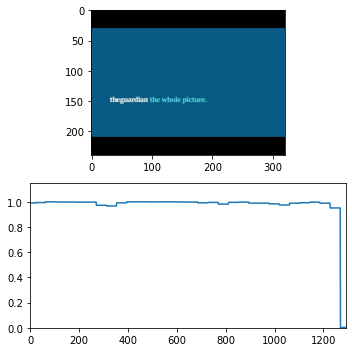

In [58]:
run_demo_c3d('/E:/LY Project/Explosion020_x264.mp4', 'Explosion020_x264')

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Number of clips in the video :  86
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed c

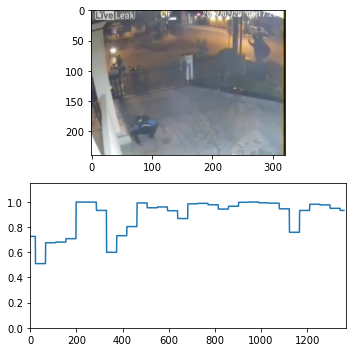

In [59]:
run_demo_c3d('/E:/LY Project/RoadAccidents001_x264.mp4', 'RoadAccidents001_x264')

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Number of clips in the video :  140
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed 

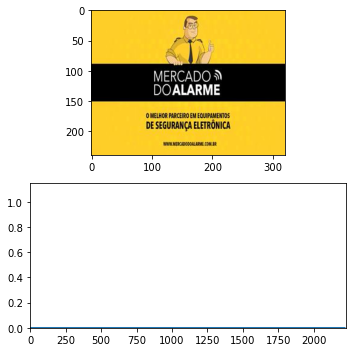

In [60]:
run_demo_c3d('/E:/LY Project/Normal_Videos480_x264.mp4', 'Normal_Videos480_x264')

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Number of clips in the video :  344
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed 

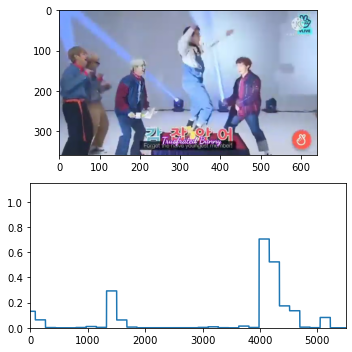

In [62]:
run_demo_c3d('/E:/LY Project/BTS.mp4','BTS')

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Number of clips in the video :  177
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed 

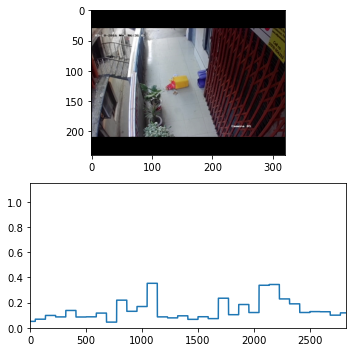

In [63]:
run_demo_c3d('E:/LY Project/Testing_Normal_Videos_Anomaly/Testing_Normal_Videos_Anomaly/Normal_Videos_003_x264.mp4','Normal_Videos_003_x264')

Number of clips in the video :  105
Models initialized
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
Processed clip :  9
Processed clip :  10
Processed clip :  11
Processed clip :  12
Processed clip :  13
Processed clip :  14
Processed clip :  15
Processed clip :  16
Processed clip :  17
Processed clip :  18
Processed clip :  19
Processed clip :  20
Processed clip :  21
Processed clip :  22
Processed clip :  23
Processed clip :  24
Processed clip :  25
Processed clip :  26
Processed clip :  27
Processed clip :  28
Processed clip :  29
Processed clip :  30
Processed clip :  31
Processed clip :  32
Processed clip :  33
Processed clip :  34
Processed clip :  35
Processed clip :  36
Processed clip :  37
Processed clip :  38
Processed clip :  39
Processed clip :  40
Processed clip :  41
Processed clip :  42
Processed clip :  43
Processed clip :  44
Processed 

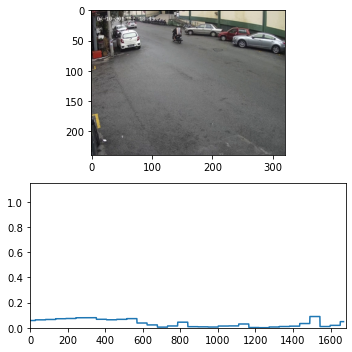

In [64]:
run_demo_c3d('E:/LY Project/Testing_Normal_Videos_Anomaly/Testing_Normal_Videos_Anomaly/Normal_Videos_033_x264.mp4','Normal_Videos_033_x264')